# Network Intrusion Detection System - NIDS

# 1. Prerequisites

## 1.1. Import Libraries

In [47]:
import os
import gc
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
from sklearn.svm import SVC

## 1.2. Define functions

In [88]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def missing_values(df):
    """
    Print a table with missing values
    """
    table = PrettyTable(["Column", "All Values", "Missing Values", "% of missing values"])
    NaN_columns = []
    columns = df.columns
    for column in columns:
        all_values = df[column].count()
        missing_values = df[column].isna().sum()
        if missing_values > 0:
            NaN_columns.append(column)
        percentage = f'{(missing_values / all_values)*100:.2f}'
        table.add_row([column, all_values, missing_values, f'{percentage}%'])
    data = table.get_string()
    #with open(f"Missing_table.txt", 'w') as f:
    #    f.write(data)
    print(table)
    if len(NaN_columns) > 0:
        print(f"Columns with missing values: {NaN_columns}")
    #print(f"Table saved as Missing_table.txt")

def hist_plot(label, count):
    _dict = {}
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Network traffic type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Network traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    #plt.savefig("Traffic_type_distribution.png")

def attack_plot(label, count):
    _dict = {}
    label = [x for x in label if x != 'BENIGN']
    count = count.iloc[1:len(count)]
    for x in range(len(label)):
        _dict[label[x]] = count.iloc[x]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(_dict.keys(), _dict.values())
    ax.set_title('Attack type distribution', fontsize=16, fontweight="bold")
    ax.set_xlabel('Traffic type')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('Distribution')
    ax.grid(which='Major', axis='both')
    #plt.savefig("attack_type_distribution.png")

In [2]:
for dirname, _, filenames in os.walk('data/CIC_IDS_2017/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/CIC_IDS_2017/prepared_train_data.npy
data/CIC_IDS_2017/prepared_train_labels.npy
data/CIC_IDS_2017/README.md
data/CIC_IDS_2017/download_dataset.sh
data/CIC_IDS_2017/TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv
data/CIC_IDS_2017/TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv
data/CIC_IDS_2017/MachineLearningCVE/Thursd

# 2. Data Analysis

In [83]:
monday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
tuesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
wednesday = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', sep=",", encoding='utf-8')
thursday_afternoon = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_ddos = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_pcap = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', sep=",", encoding='utf-8')
friday_morning = pd.read_csv('data/CIC_IDS_2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv', sep=",", encoding='utf-8')
monday.name = 'Monday'
tuesday.name = 'Tuesday'
wednesday.name = 'Wednesday'
thursday_morning.name = 'Thursday_Morning'
thursday_afternoon.name = 'Thursday_Afternoon'
friday_ddos.name = 'Friday_DDoS'
friday_pcap.name = 'Friday_Pcap'
friday_morning.name = 'Friday_Morning'

In [85]:
dataframes = [monday, tuesday, wednesday, thursday_morning, thursday_afternoon, friday_ddos, friday_morning, friday_pcap]
data = pd.concat(dataframes)

In [86]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 286466
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max               

In [8]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [9]:
data[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [10]:
data[' Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [11]:
data = data.replace([-np.inf, np.inf], np.nan)
missing_values(data)

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2830743   |       0        |        0.00%        |
|         Flow Duration        |  2830743   |       0        |        0.00%        |
|       Total Fwd Packets      |  2830743   |       0        |        0.00%        |
|    Total Backward Packets    |  2830743   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2830743   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2830743   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2830743   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2830743   |       0        |   

In [12]:
data.dropna(inplace=True)
missing_values(data)

+------------------------------+------------+----------------+---------------------+
|            Column            | All Values | Missing Values | % of missing values |
+------------------------------+------------+----------------+---------------------+
|       Destination Port       |  2827876   |       0        |        0.00%        |
|         Flow Duration        |  2827876   |       0        |        0.00%        |
|       Total Fwd Packets      |  2827876   |       0        |        0.00%        |
|    Total Backward Packets    |  2827876   |       0        |        0.00%        |
| Total Length of Fwd Packets  |  2827876   |       0        |        0.00%        |
|  Total Length of Bwd Packets |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Max    |  2827876   |       0        |        0.00%        |
|     Fwd Packet Length Min    |  2827876   |       0        |        0.00%        |
|    Fwd Packet Length Mean    |  2827876   |       0        |   

In [13]:
label = data[' Label'].value_counts().index.tolist()
count = data[' Label'].value_counts()

In [14]:
label

['BENIGN',
 'DoS Hulk',
 'PortScan',
 'DDoS',
 'DoS GoldenEye',
 'FTP-Patator',
 'SSH-Patator',
 'DoS slowloris',
 'DoS Slowhttptest',
 'Bot',
 'Web Attack � Brute Force',
 'Web Attack � XSS',
 'Infiltration',
 'Web Attack � Sql Injection',
 'Heartbleed']

In [15]:
count

 Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

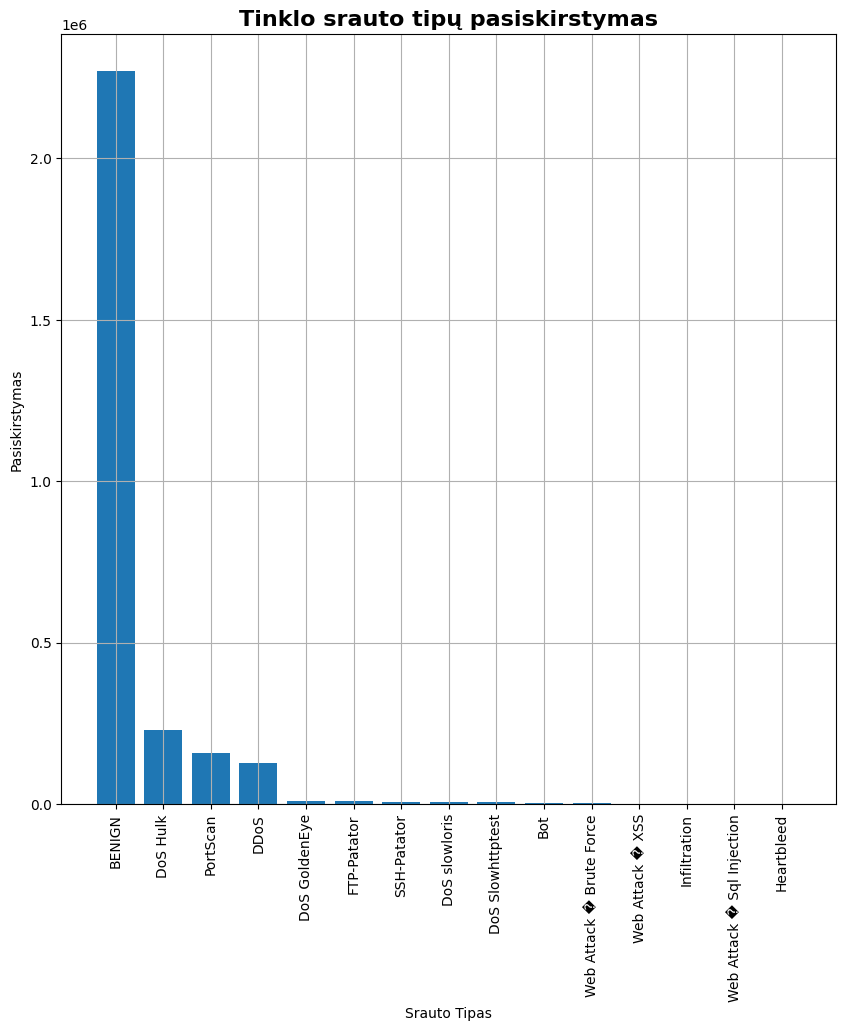

In [17]:
hist_plot(label, count)

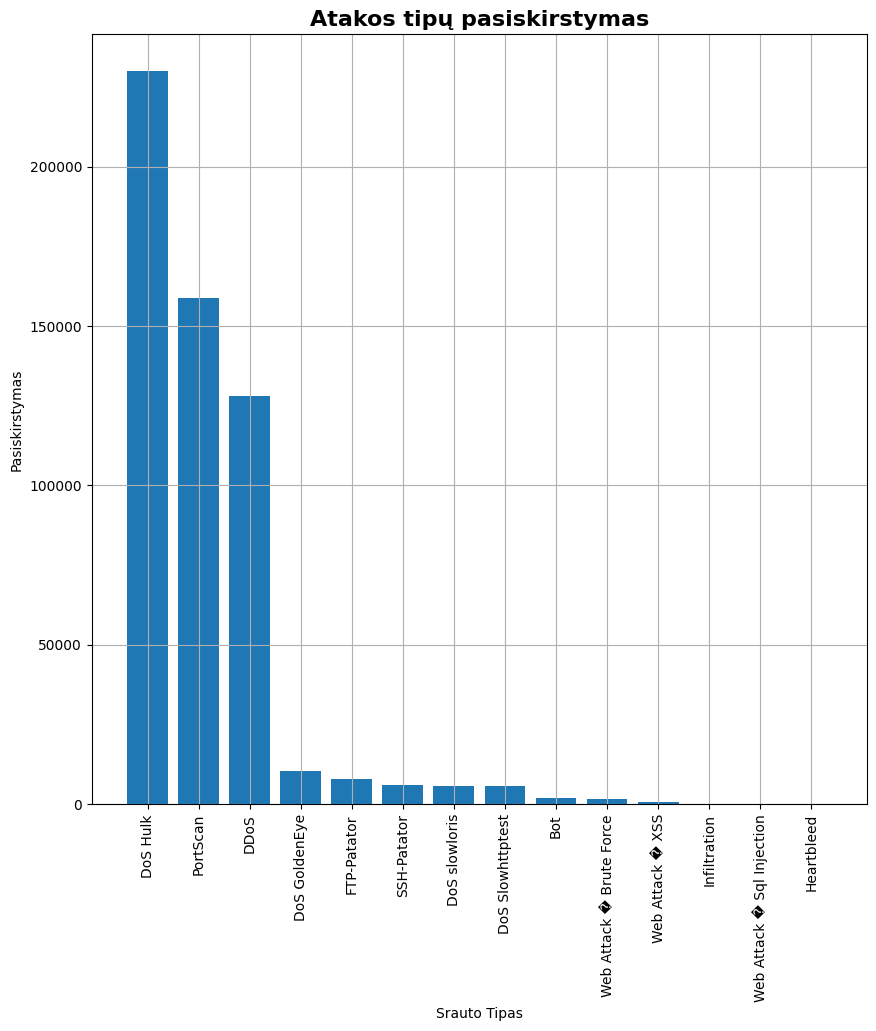

In [19]:
attack_plot(label, count)

# 4. Prepare data

In [20]:
X = data.drop([' Label'], axis=1)
y = data[' Label']

In [21]:
X.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [22]:
y.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'Infiltration', 'DDoS', 'Bot',
       'PortScan'], dtype=object)

In [23]:
len(y.unique())

15

## 4.1 Data Normalization

In [24]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [25]:
X

array([[ 2.25050642, -0.43961241, -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [ 2.25050642, -0.4396125 , -0.00982461, ..., -0.10951643,
        -0.35707153, -0.33918443],
       ...,
       [-0.41689841, -0.4348067 ,  0.08083571, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [-0.41689841, -0.43536915,  0.05417091, ..., -0.10951643,
        -0.35707153, -0.33918443],
       [-0.41689841, -0.43406035,  0.04883795, ..., -0.10951643,
        -0.35707153, -0.33918443]])

## 4.2 Encode data

In [26]:
onehotencoder = OneHotEncoder()
y = y.values.reshape(-1, 1)
y = onehotencoder.fit_transform(y).toarray()
y = y[:, 0]

In [27]:
y

array([1., 1., 1., ..., 1., 1., 1.])

## 4.3 Principal component analysis

In [28]:
%%time
num_components = 10
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X)
feature_selector = SelectKBest(score_func=f_classif, k='all')
X = feature_selector.fit_transform(X_pca, y)
X = X.reshape(X.shape[0], num_components, 1)

CPU times: user 4.42 s, sys: 1.19 s, total: 5.61 s
Wall time: 1.51 s


## 4.4 Save data

In [29]:
np.save('data/CIC_IDS_2017/prepared_train_data.npy', X)
np.save('data/CIC_IDS_2017/prepared_train_labels.npy', y)

## 4.5 Load data

In [30]:
X = np.load('data/CIC_IDS_2017/prepared_train_data.npy')
y = np.load('data/CIC_IDS_2017/prepared_train_labels.npy')

In [31]:
X

array([[[-2.20341917],
        [-0.04649812],
        [ 0.5388577 ],
        ...,
        [-0.18823211],
        [-0.24876228],
        [ 1.3845989 ]],

       [[-2.65783247],
        [-0.06213898],
        [ 0.80433841],
        ...,
        [ 0.16800908],
        [ 1.10542934],
        [-1.99055778]],

       [[-2.65783247],
        [-0.06213898],
        [ 0.80433841],
        ...,
        [ 0.16800908],
        [ 1.10542934],
        [-1.99055778]],

       ...,

       [[ 2.96579199],
        [ 0.59986647],
        [-5.2269146 ],
        ...,
        [ 2.82679641],
        [ 0.33933268],
        [-0.2927417 ]],

       [[ 2.00624895],
        [ 0.45068367],
        [-4.21600076],
        ...,
        [ 2.46204332],
        [-0.01862949],
        [-0.30590085]],

       [[ 1.99913966],
        [ 0.43758331],
        [-4.20599781],
        ...,
        [ 2.45912152],
        [-0.02805093],
        [-0.30215974]]])

In [32]:
y

array([1., 1., 1., ..., 1., 1., 1.])

# 5. Create a model

Testing these models:
1. K Nearest Neighbour
2. Random Forest
3. Gradient Boost:
    * XGBoost;
    * CatBoost;
    * LightGBM.
4. Support Vector Machine;
5. Neural Network.

In [33]:
results_dict = {}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

## 5.1. K Nearest Neighbour

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["KNN"] = results

In [ ]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

## 5.2. Random Forest

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RF"] = results

In [ ]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

## 5.3. XGBoost

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["XGBoost"] = results

In [ ]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

## 5.4. LightGBM

In [ ]:
lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["LightGBM"] = results

In [ ]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

## 5.5. Support Vector Machine

In [ ]:
svc_clf = SVC()
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["SVM"] = results

In [ ]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"]).T

## 5.6. Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [63]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/IDS_test/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,232 (270.44 KB)

 Trainable params: 69,232 (270.44 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
%%time
model.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

Epoch 1/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 135s 2ms/step - accuracy: 0.9615 - loss: 0.0910 - val_accuracy: 0.9776 - val_loss: 0.0535
Epoch 2/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step - accuracy: 0.9755 - loss: 0.0559 - val_accuracy: 0.9815 - val_loss: 0.0470
Epoch 3/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms/step - accuracy: 0.9775 - loss: 0.0519 - val_accuracy: 0.9798 - val_loss: 0.0450
Epoch 4/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step - accuracy: 0.9785 - loss: 0.0498 - val_accuracy: 0.9819 - val_loss: 0.0446
Epoch 5/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step - accuracy: 0.9788 - loss: 0.0492 - val_accuracy: 0.9800 - val_loss: 0.0450
Epoch 6/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 131s 2ms/step - accuracy: 0.9799 - loss: 0.0469 - val_accuracy: 0.9837 - val_loss: 0.0410
Epoch 7/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 128s 2ms/step - accuracy: 0.9806 - loss: 0.0457 - val_accuracy: 0.9791 - val_loss: 0.0463
Epoch 8/20
61595/61595 ━━━━━━━━━━━━━━━━━━━━ 128s 2ms/step - ac

In [66]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 13s 997us/step


In [67]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

13256/13256 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9926 - loss: 0.0254


In [68]:
results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["RNN"] = results

In [69]:
pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"]).T

,RNN,KNN
Accuracy,0.992824,0.996942
Precision,0.992815,0.996951
F1,0.992818,0.996945
Recall,0.992824,0.996942
MAE,0.007176,0.003058
MSE,0.007176,0.003058
RMSE,0.084712,0.055296


# 6. Plotting data